In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from numpy.random import RandomState
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LogisticRegression
from math import log
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from scipy.spatial import distance
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#read the dataset
dataset=pd.read_csv("clean_dataset/zoabi/zoabi_b_preprocessed.csv")
dataset=shuffle(dataset)

In [3]:
x=dataset.values

In [4]:
dfX = pd.DataFrame(x)
dfX.columns=dataset.columns
X_Final=dfX

In [5]:
index=list()
for i in range(0,len(X_Final)):
    index.append(i)

In [6]:
#X_Final.drop(['id'],axis=1,inplace=True)
X_Final['index']=index

In [7]:
train_len=int(len(dataset)*0.1)
test_len=int(len(dataset)*0.1)
unlabel_len=int(len(dataset)*0.8)

In [8]:
#take initial sample
initial_label=X_Final.sample(n=round(train_len),random_state=101)
#delete from unlabel
unlabel=X_Final.drop(initial_label.index)
test_dataset=unlabel.sample(n=round(test_len),replace=False)
unlabel=unlabel.drop(test_dataset.index)

In [9]:
clf = RandomForestClassifier(max_depth=4, random_state=0,n_estimators=50)

In [10]:
minority_sample=list()
gmean_score=list()
f1_scr=list()
acc_scr=list()
for i in range(0,8):
    print("iteration ",i)
    #if i >0:
    #   unlabel.drop(['entropy','cluster','similarity'],axis=1,inplace=True)
    X_train=initial_label.drop(['Label'],axis=1)
    y_train=initial_label['Label']
    clf.fit(X_train,y_train)
    X_U=unlabel.drop(['Label'],axis=1)
    
    #predict
    
    probs=clf.predict_proba(X_U)
    #calculate the entropy
    entropy=list()
    for p in probs:
        ent=0
        ent1=-p[0] * log(p[0],2)
        ent2=-p[1] * log(p[1],2)
        ent=ent1+ent2
        entropy.append(ent)
    X_cluster=pd.DataFrame(X_U)
    X_cluster['entropy']=entropy
    kmeans = KMeans(n_clusters=60, random_state=100,max_iter=600,n_init=10)
    kmeans.fit(X_cluster)
    labels = kmeans.predict(X_cluster)
    

    data_cluster=unlabel.copy()
    data_cluster['entropy']=entropy
    data_cluster['cluster']=labels
    X_cluster=X_cluster.to_numpy()
    similarity_to_center=list()
    for i, instance in enumerate(X_cluster):
        cluster_label = labels[i]
        centroid = kmeans.cluster_centers_[cluster_label] # cluster center of the cluster of that instance
        similarity=distance.euclidean(instance,centroid)
        similarity_to_center.append(similarity)
    data_cluster['similarity']=similarity_to_center
    cluster_labels=pd.DataFrame({"index":data_cluster['index'],'cluster':labels,
                                    'uncertainty':data_cluster['entropy'],
                                 'similarity':similarity_to_center})
    cluster_dict=dict()
    #creating the dataframe for each cluster
    for item in range(0,60):
        cluster_dict['cluster_{0}'.format(item)]=cluster_labels[cluster_labels['cluster']==item] 
    #Create the dataframe for each cluster
    for i in range(0,60):
            globals()['cluster_{}'.format(i)] = pd.DataFrame(cluster_dict['cluster_{}'.format(i)])
    for i in range(0,60):
        globals()['cluster_{}'.format(i)]=globals()['cluster_{}'.format(i)].sort_values(by="similarity",ascending=True)
    center_data=pd.DataFrame()
    
    for i in range(0,60):
        data1=globals()['cluster_{}'.format(i)]
        mn=data1['similarity'].median()
        center=data1[data1['similarity']<=mn]
        #center=center.sort_values(by='similarity',ascending=True)
        data=center.head(1)
        center_data=center_data.append(data)
       
    #get the label
    sample_candidate=center_data.merge(data_cluster,on='index',how='left')
    sample_candidate.drop(['cluster_x','uncertainty','similarity_x',
               'entropy','cluster_y','similarity_y'],axis=1,inplace=True)

    

    majority=sample_candidate[sample_candidate['Label']==0]
    minority=sample_candidate[sample_candidate['Label']==1]
    #print(len(majority))
    #print(len(minority))
    sample_majority=majority.sample(n=len(minority),replace=True)
    frame=[minority,sample_majority]
    new_sample=pd.concat(frame)
    #print(len(new_sample))
    initial_label=initial_label.append(new_sample)

   
    
    
    #model performance
    X=initial_label.drop(['Label'],axis=1)
    y=initial_label['Label']
    X_test=test_dataset.drop(['Label'],axis=1)
    y_test=test_dataset['Label']
    
    clf.fit(X,y)
    y_pred=clf.predict(X_test)

    gmean=geometric_mean_score(y_pred,y_test)
    f1=f1_score(y_pred,y_test)
    gmean_score.append(gmean)
    f1_scr.append(f1)
    ac=accuracy_score(y_pred,y_test)
    acc_scr.append(ac)

    #remove from unlabel
    #unlabel.drop(['entropy','cluster','similarity'],axis=1,inplace=True)
    unlabel=unlabel[~unlabel['index'].isin(sample_candidate['index'])]

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7


In [11]:
gmean_score

[0.7749090472183965,
 0.7749090472183965,
 0.7749090472183965,
 0.7749090472183965,
 0.7749090472183965,
 0.7749090472183965,
 0.7749090472183965,
 0.7749090472183965]

In [12]:
f1_scr

[0.5287470370982856,
 0.5287470370982856,
 0.5287470370982856,
 0.5287470370982856,
 0.5287470370982856,
 0.5287470370982856,
 0.5287470370982856,
 0.5287470370982856]

In [13]:
acc_scr

[0.9184699161715479,
 0.9184699161715479,
 0.9184699161715479,
 0.9184699161715479,
 0.9184699161715479,
 0.9184699161715479,
 0.9184699161715479,
 0.9184699161715479]

In [14]:
initial_label.drop(['index'],axis=1,inplace=True)

In [15]:
X=initial_label.drop(['Label'],axis=1)
y=initial_label['Label']

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [17]:
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=0)

In [18]:
import sklearn.metrics as metrics

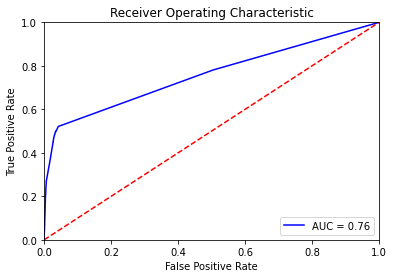

In [19]:
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
#false_rate=pd.DataFrame([fpr])
#true_rate=pd.DataFrame([tpr])
#auc_rate=pd.DataFrame([roc_auc])
#false_rate.to_csv("auc_curve/chinese/fpr_ds3_kaggle.csv",index=False)
#true_rate.to_csv("auc_curve/chinese/tpr_ds3_kaggle.csv",index=False)
#auc_rate.to_csv("auc_curve/chinese/auc_ds3_kaggle.csv",index=False)